# Paraguay Electricity Consumption & Weather Data Visualization

This notebook explores the raw Paraguay electricity consumption and meteorological data. The goal is to understand the data and relationships between substations, feeders, and weather features, as a first step toward predicting total consumption.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
consumption_path = '../../data/paraguay/electricity-consumption-raw.csv'
weather_path = '../../data/paraguay/meteorological-raw.csv'
substations_path = '../../data/paraguay/substations-geographical-location.csv'

# Load data
df_consumption = pd.read_csv(consumption_path)
df_weather = pd.read_csv(weather_path)
df_substations = pd.read_csv(substations_path)

In [8]:
print('\nMissing values in weather:')
print(df_weather.isnull().sum())


Missing values in weather:
datetime        0
temperature     0
humidity       81
wind_speed      1
pressure        4
dtype: int64


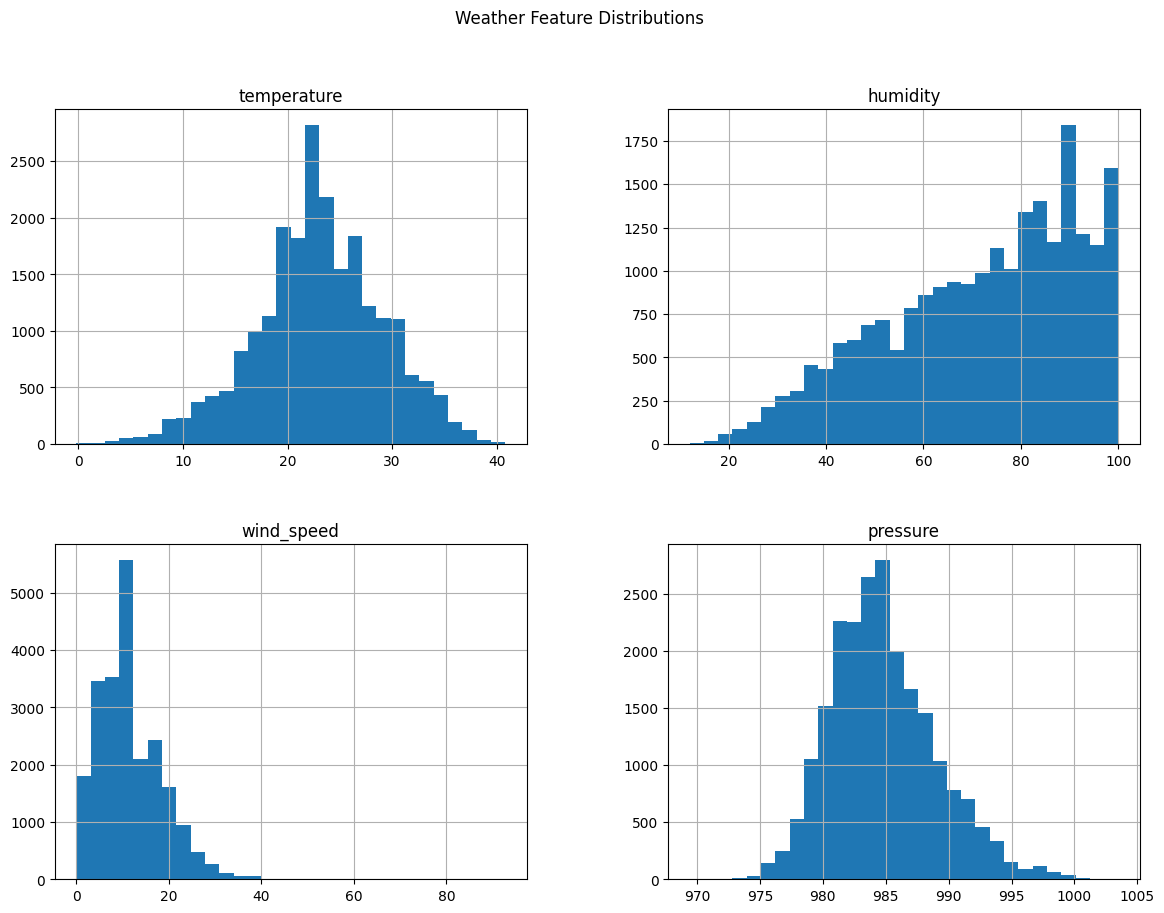

In [5]:
# Plot histograms of weather features
weather_numeric = df_weather.select_dtypes(include='number')
weather_numeric.hist(figsize=(14,10), bins=30)
plt.suptitle('Weather Feature Distributions')
plt.show()

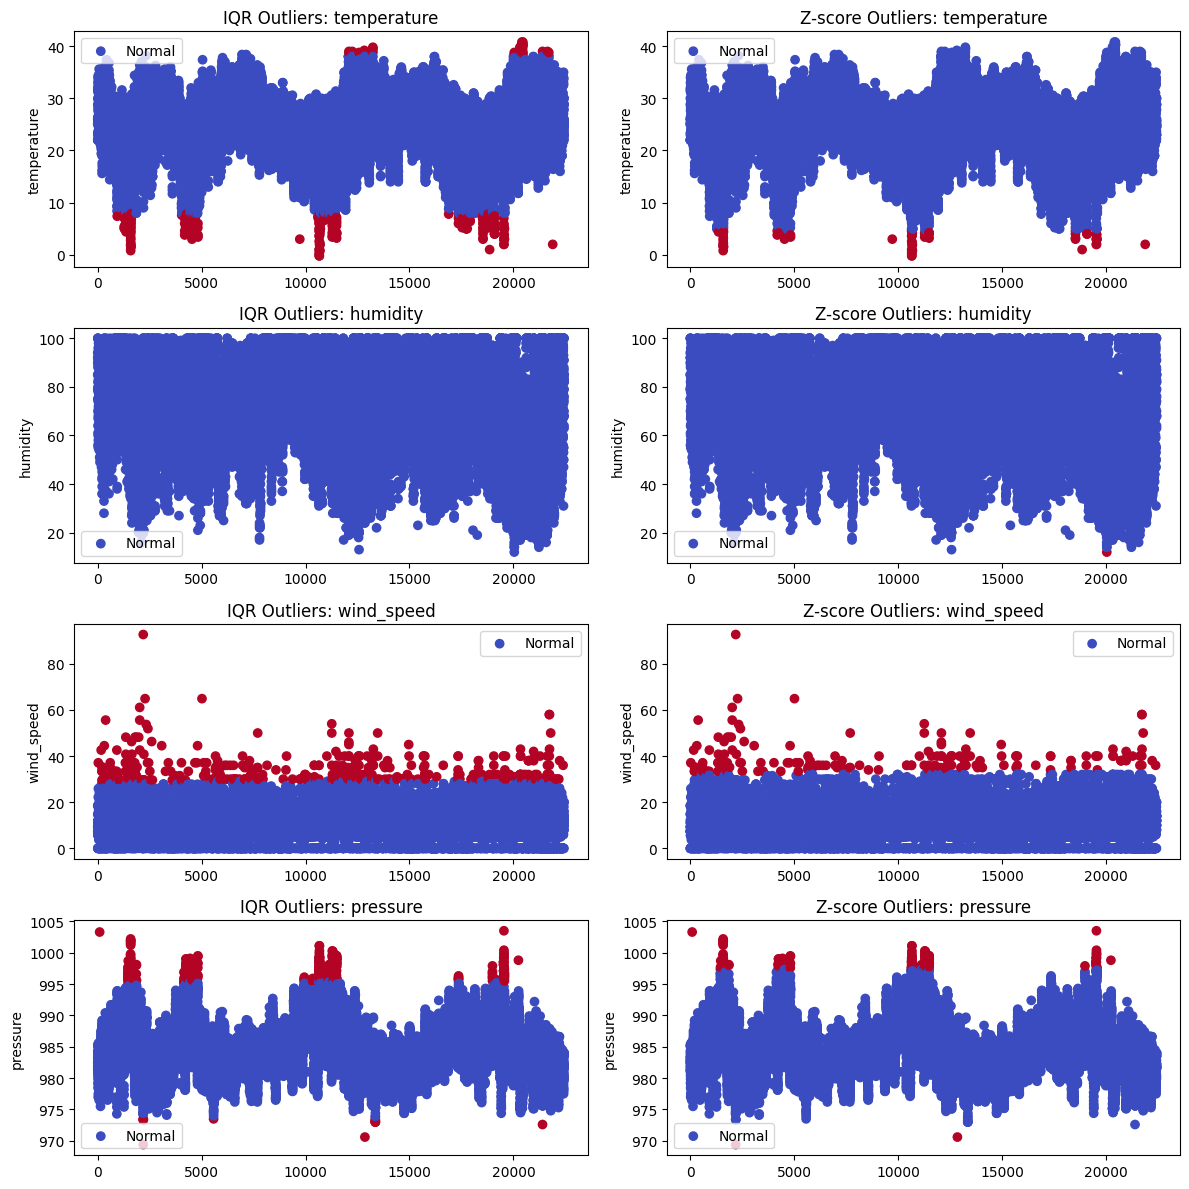

In [6]:
# Outlier detection using IQR and Z-score methods
from scipy.stats import zscore

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (df[column] < lower) | (df[column] > upper)

def detect_outliers_zscore(df, column, threshold=3):
    z_scores = zscore(df[column].dropna())
    outliers = abs(z_scores) > threshold
    # Reindex to match original DataFrame
    outlier_index = df[column].dropna().index[outliers]
    mask = pd.Series(False, index=df.index)
    mask.loc[outlier_index] = True
    return mask

# Choose a few numeric weather columns for demonstration
weather_cols = weather_numeric.columns[:4]  # Select first 4 numeric columns for brevity

fig, axes = plt.subplots(len(weather_cols), 2, figsize=(12, 3*len(weather_cols)))
for i, col in enumerate(weather_cols):
    # IQR method
    iqr_outliers = detect_outliers_iqr(df_weather, col)
    axes[i, 0].scatter(df_weather.index, df_weather[col], c=iqr_outliers, cmap='coolwarm', label='Outlier')
    axes[i, 0].set_title(f'IQR Outliers: {col}')
    axes[i, 0].set_ylabel(col)
    # Z-score method
    z_outliers = detect_outliers_zscore(df_weather, col)
    axes[i, 1].scatter(df_weather.index, df_weather[col], c=z_outliers, cmap='coolwarm', label='Outlier')
    axes[i, 1].set_title(f'Z-score Outliers: {col}')
    axes[i, 1].set_ylabel(col)
for ax in axes.flat:
    ax.legend(['Normal', 'Outlier'])
plt.tight_layout()
plt.show()

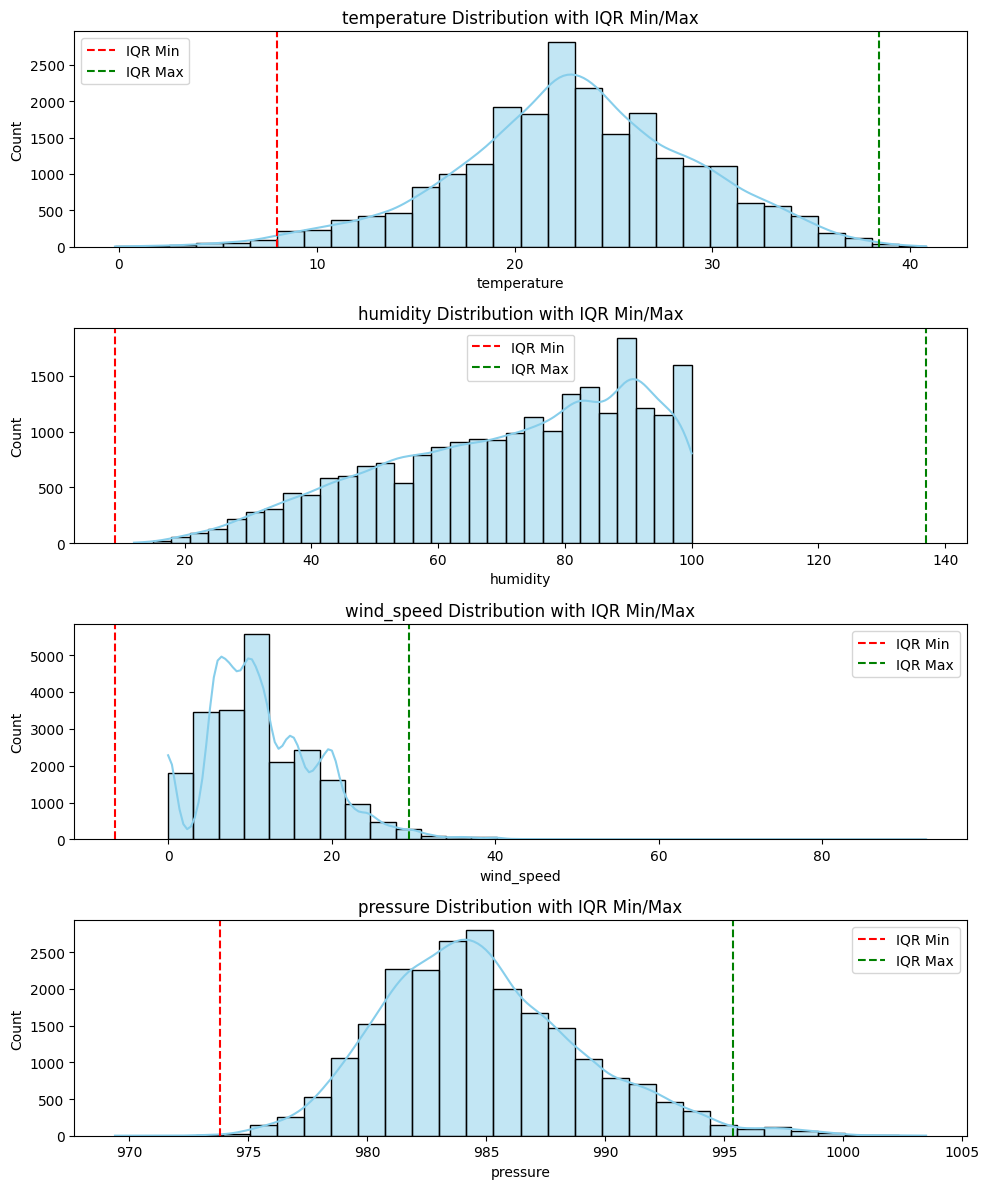

In [7]:
# Plot distributions with IQR min/max lines for selected weather columns
fig, axes = plt.subplots(len(weather_cols), 1, figsize=(10, 3*len(weather_cols)))
if len(weather_cols) == 1:
    axes = [axes]
for i, col in enumerate(weather_cols):
    data = df_weather[col].dropna()
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    sns.histplot(data, bins=30, ax=axes[i], kde=True, color='skyblue')
    axes[i].axvline(lower, color='red', linestyle='--', label='IQR Min')
    axes[i].axvline(upper, color='green', linestyle='--', label='IQR Max')
    axes[i].set_title(f'{col} Distribution with IQR Min/Max')
    axes[i].legend()
plt.tight_layout()
plt.show()

## Outlier Detection Summary
Both the IQR and Z-score methods are commonly used for outlier detection in numerical data:

- **IQR Method**: Robust to non-normal distributions and less sensitive to extreme values. It is preferred when the data is skewed or contains many outliers, as it uses the interquartile range (middle 50% of data).

- **Z-score Method**: Assumes data is approximately normally distributed. It is sensitive to extreme values and may not perform well if the data is heavily skewed or contains many outliers.


**Recommendation:**

- Use the **IQR method** for weather data, as meteorological features often have skewed distributions and may not be strictly normal. The IQR method is more robust and less likely to be influenced by extreme values.